# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

This one is a classification problem because we are trying to identify a student as need early intervention or does not need early intervention.

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 10)
plt.style.use('ggplot')
import matplotlib.pyplot as pl

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
# Note: The last column 'passed' is the target/label, all other are feature columns
student_data.head()

Student data read successfully!


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,yes
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,yes
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,yes


In [87]:
student_data.passed.value_counts()

1    265
0    130
Name: passed, dtype: int64

In [3]:
student_data.groupby(student_data.passed).mean()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences
passed,,,,,,,,,,,,,
no,17.023077,2.569231,2.353846,1.492308,1.946154,0.692308,3.884615,3.261538,3.400000,1.553846,2.346154,3.684615,6.761538
yes,16.535849,2.837736,2.603774,1.426415,2.079245,0.158491,3.973585,3.222642,2.966038,1.445283,2.264151,3.490566,5.192453


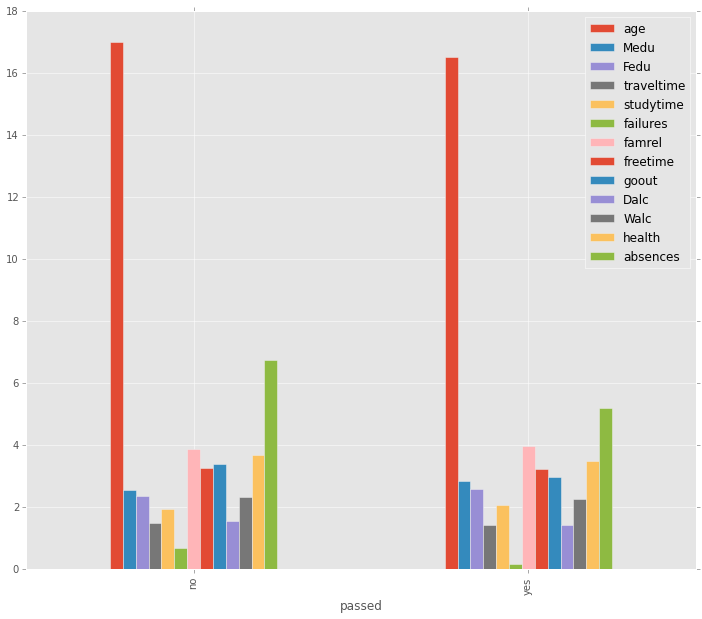

In [4]:
student_data.groupby(student_data.passed).mean().plot(kind='bar')

Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [5]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students = student_data.shape[0]
n_features = student_data.shape[1]
student_data.passed =student_data.passed.replace({'yes':1,'no':0})
n_passed = np.sum(student_data.passed)
n_failed = n_students - n_passed
grad_rate = float(n_passed)/n_students *100
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 31
Graduation rate of the class: 67.09%


## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [6]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:-"
print X_all.head()  # print the first 5 rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...    

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [7]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [8]:
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

from sklearn.cross_validation import ShuffleSplit
ID = ShuffleSplit(student_data.shape[0], n_iter=1, train_size=0.75)

# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
for train_index, test_index in ID:
    #print train_index
    X_train = X_all.iloc[train_index,]
    y_train = y_all.iloc[train_index,]
    X_test = X_all.iloc[test_index,]
    y_test = y_all.iloc[test_index,]
print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

Training set: 296 samples
Test set: 40 samples


In [9]:
from sklearn.metrics import f1_score
def performance_metric(y_true, y_predict):
    """ Calculates and returns the total error between true and predicted values
        based on a performance metric chosen by the student. """
    
    error = f1_score((y_true, y_predict))
    return error

## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What is the theoretical O(n) time & space complexity in terms of input size?
- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

In [10]:
# Train a model
import time

def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)

# TODO: Choose a model, import it and instantiate an object

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()

# Fisklearn.ensemble training data
train_classifier(clf, X_train, y_train)  # note: using entire training set here
print clf  # you can inspect the learned model by printing it

Training GradientBoostingClassifier...
Done!
Training time (secs): 0.100
GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


In [77]:
from sklearn.learning_curve import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects
    """
    
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on") 
    if ylim:
        plt.ylim(ylim)
    plt.title(title)

In [131]:
def plot_validation_curve(estimator, X_train, y_train, param_name, param_range, ylim= None, semilog= True):
    
    param_range = param_range  
    train_scores, test_scores = validation_curve(estimator, X_train, y_train, param_name= param_name, param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title("Validation Curve")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    if semilog == True:        
        plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
        plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
        plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
        plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
        plt.legend(loc="best")
        if ylim:
            plt.ylim(ylim)
        plt.show()
    else:
        plt.plot(param_range, train_scores_mean, label="Training score", color="r")
        plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
        plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
        plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
        plt.legend(loc="best")
        if ylim:
            plt.ylim(ylim)
        plt.show()

In [11]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target.values, y_pred, pos_label=1)

train_f1_score = predict_labels(clf, X_train, y_train)
print "F1 score for training set: {}".format(train_f1_score)

Predicting labels using GradientBoostingClassifier...
Done!
Prediction time (secs): 0.004
F1 score for training set: 0.980582524272


In [12]:
# Predict on test data
print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

Predicting labels using GradientBoostingClassifier...
Done!
Prediction time (secs): 0.004
F1 score for test set: 0.830769230769


# Initial Model building (no parameter tuning)

In [13]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    train_classifier(clf, X_train, y_train)
    print "F1 score for training set: {}".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

# TODO: Run the helper function above for desired subsets of training data
# Note: Keep the test set constant

In [14]:
# TODO: Train and predict using two other models
from sklearn.svm import SVC
clf = SVC()
train_classifier(clf, X_train, y_train) 
print clf

train_f1_score = predict_labels(clf, X_train, y_train)
print "F1 score for training set: {}".format(train_f1_score)

# Predict on test data
print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

Training SVC...
Done!
Training time (secs): 0.004
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Predicting labels using SVC...
Done!
Prediction time (secs): 0.004
F1 score for training set: 0.868817204301
Predicting labels using SVC...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.818181818182


In [15]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

train_classifier(clf, X_train, y_train) 
print clf

train_f1_score = predict_labels(clf, X_train, y_train)
print "F1 score for training set: {}".format(train_f1_score)

# Predict on test data
print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

Training LogisticRegression...
Done!
Training time (secs): 0.008
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.012
F1 score for training set: 0.832183908046
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.838709677419


## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

Choosing the best model is the critical task of a supervised machine learning model. It is also important to tune the parameters of the model to avoid any overfitting. For this classification task, I chose support vector classifier, gradient boosting classifier and a simple logistic regression model.

In [16]:
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV

In [79]:
LogisticRegression?

## Tuning the Logistic Regression

We will use regularized logistic regression, and tune the cost parameter. The 'C' parameter in scikit-learn is the inverse of the regularization strength. A very low 'C' value specifies **stronger** regularization. 'L1' and 'L2' are two different types of regularization that are used often, 'L2' (euclidian) penalizes the model heavilly.

The strengths of Logistic regression are:

* We can calculate class-probabilities
* Simple linear model, less number of hyperparameters implies easy tuning

Unfortunately, it might not capture non-linearities in the input data. Domain knowledge becomes crucial when tuning parameters in logistic regression. Moreover, as this is a linear model, it is susceptible to outliers.

GridSearchCV is used to define a grid, and search for hyperparameters. For this training data, a cost of 0.1 and 'L1' penalty seems to perform well.

In [66]:
param = {'C':[0.1,0.06,0.07,0.08,0.09,0.01,0.02,0.03,0.04,0.05,0.5,1,10,100,1000],
        'penalty':['l2','l1']}

In [67]:
lrclf = GridSearchCV(LogisticRegression(penalty='l2'),param_grid=param,n_jobs=-1,cv=10)

In [68]:
lrclf.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'penalty': ['l2', 'l1'], 'C': [0.1, 0.06, 0.07, 0.08, 0.09, 0.01, 0.02, 0.03, 0.04, 0.05, 0.5, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [169]:
print lrclf.best_params_
print lrclf.best_score_

{'penalty': 'l1', 'C': 0.1}
0.722972972973


In [170]:
train_f1_score = predict_labels(lrclf.best_estimator_, X_train, y_train)
print train_f1_score
print "F1 score for test set: {}".format(predict_labels(lrclf.best_estimator_, X_test, y_test))

Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.002
0.824524312896
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.830769230769


The training and testing accuracies are quite close, this gives a hint that this model is not overfitting the training data.

# Learning Curves for Logistic Regression

In any machine learning model, a trade off between bias and variance is necessary to avoid overfitting. It is important to plot the learning and validation curves of the model to see if there is any overfitting. 

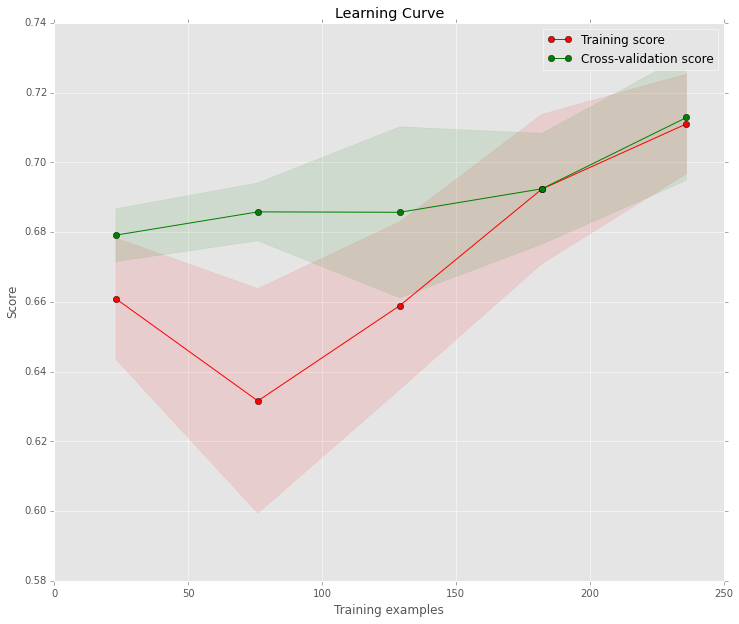

In [78]:
plot_learning_curve(lrclf.best_estimator_,X= X_train.values, y= y_train.values,title= 'Learning Curve',cv=10)

In the above graph, the horizantal axis shows the number of training examples used to build the model and the vertical axis shows the accuracy of the classifier. By default, plot_learning_curve function uses a 10 fold cross validation and the scores were averaged. The alpha blue and red shows one standard deviation from the mean accuracy score.

After feeding all the training examples, one can see that the training and testing accuracies are quite close to each other. This implies that our model is not overfitting the training data. 

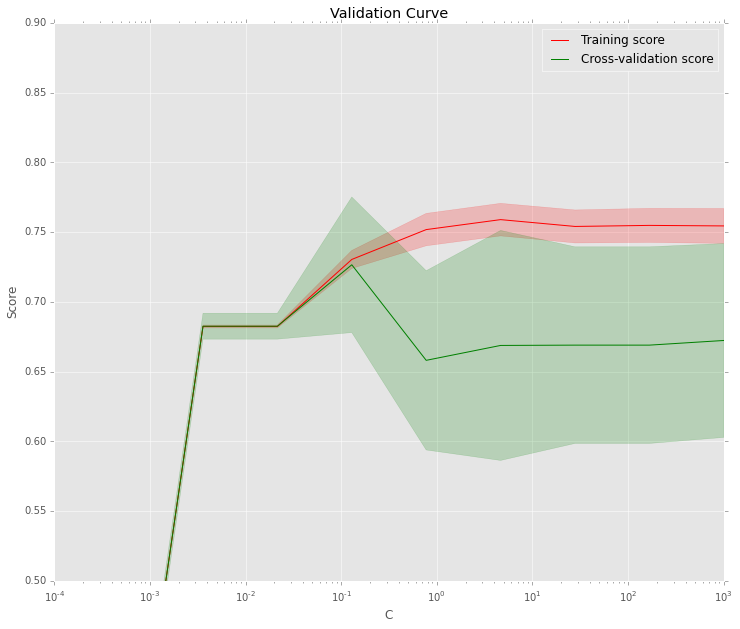

In [171]:
plot_validation_curve(estimator=LogisticRegression(penalty='l1'), X_train=X_train, y_train= y_train,
                     param_name='C', param_range= np.logspace(-4,3,10), ylim= (0.5, 0.9),semilog= True)

We can infer bias-variance trade off from the learning curve, where as validation curve can be used to select the best hyperparameters for a given data set. The 'plot_validation_curve' function is used to plot the accuracy score with respect to one hyperparameter.

As we already know, 'L1' regularization performed better on this dataset. The only other hyperparameter was Cost 'C'. From the graph, we can see when the cost is between (0.01,0.1) the training and validation scores are quite close. As C is increased, we can clearly see the model overfitting the training data, and performing worse on the test set. Thus, a 'C' around 0.05 seems to work really well on this dataset.

# Tuning Gradient Boosting

Gradient boosted classification/regression trees are a set of powerful machine learning models that can be adapted to different kinds of data. This is a more complex model, having higher number of hyperparameters, making hyperparameter tuning more complex.

On real world data, gradient boosting works really well as evidenced by most of the Kaggle competetions. In GB, we build an ensemble of shallow trees, where each model performs marginally better than a random class assignment (accuracy > 0.5 for binary classification). We use the error from the previous tree, and fit another tree such that the new tree will reduce some error from the previous tree. In this way, we build an ensemble of trees, and assign different weights based on how well they perform. We end up with a very good classifier in the end.


In [174]:
param = {'n_estimators':[10,11,12,13,14,15,16,17,18,19,20,50,100],
         'max_depth':[2,3,4,5,6,7,8,9]   
}
gbcclf = GridSearchCV(GradientBoostingClassifier(),param_grid= param,n_jobs=-1,cv=10)
gbcclf.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'n_estimators': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 50, 100], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [175]:
print gbcclf.best_params_

{'n_estimators': 20, 'max_depth': 3}


In [176]:
train_f1_score = predict_labels(gbcclf.best_estimator_, X_train, y_train)
print train_f1_score
print "F1 score for test set: {}".format(predict_labels(gbcclf.best_estimator_, X_test, y_test))

Predicting labels using GradientBoostingClassifier...
Done!
Prediction time (secs): 0.002
0.897321428571
Predicting labels using GradientBoostingClassifier...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.8


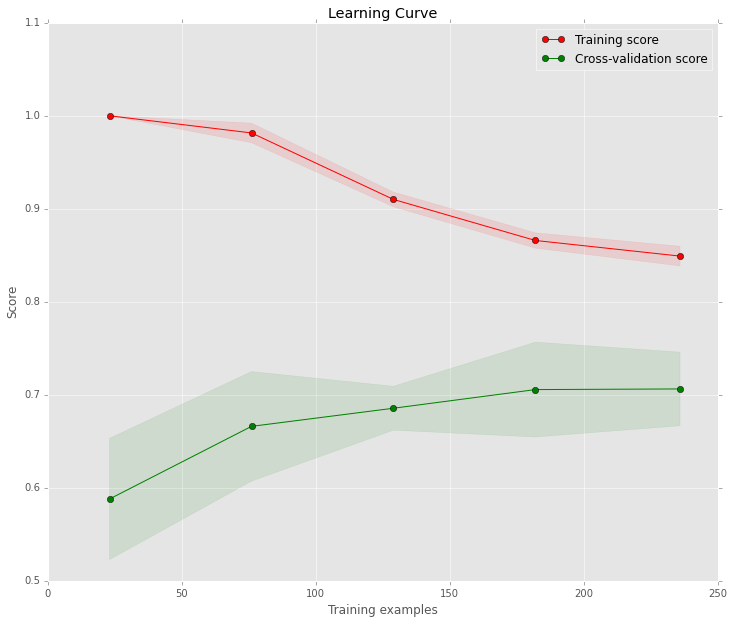

In [177]:
plot_learning_curve(gbcclf.best_estimator_,X= X_train.values, y= y_train.values,title= 'Learning Curve',cv=10)

A small gap between training and testing accuracies seems to indicate that our model might be overfitting the training data.

Up till now, we have been doing grid search for tuning hyperparameters. Recent [research](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) seems to suggest that a random search might work better than doing a shallow grid search. We will try to search randomly using RandomizedSearchCV from scikit-learn.

In [178]:
from scipy.stats import randint as sp_randint
param_dist = {"max_depth":sp_randint(2,4),
              "n_estimators": sp_randint(5,16),
              "learning_rate":[0.01,0.02,0.03,0.04,0.05,0.001,0.06,0.07,0.08,0.09]
             }
clf = GradientBoostingClassifier()
gbcclfr = RandomizedSearchCV(clf, param_distributions= param_dist, n_iter=500,cv=10,n_jobs=-1)
gbcclfr.fit(X_train,y_train)
gbcclfr.best_params_

{'learning_rate': 0.09, 'max_depth': 3, 'n_estimators': 9}

In [179]:
train_f1_score = predict_labels(gbcclfr.best_estimator_, X_train, y_train)
print train_f1_score
print "F1 score for test set: {}".format(predict_labels(gbcclfr.best_estimator_, X_test, y_test))

Predicting labels using GradientBoostingClassifier...
Done!
Prediction time (secs): 0.001
0.864516129032
Predicting labels using GradientBoostingClassifier...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.8


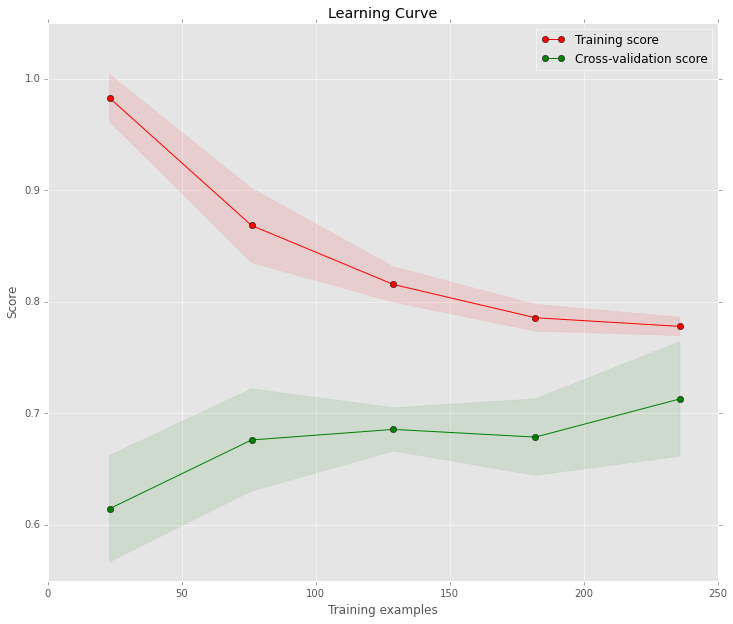

In [180]:
plot_learning_curve(gbcclfr.best_estimator_,X= X_train.values, y= y_train.values,title= 'Learning Curve',cv=10,ylim=(.55,1.05))

RandomizedSearchCV did find better hyperparameters. The gap between training and crossvalidation scores is minimum, which indicates good fit.

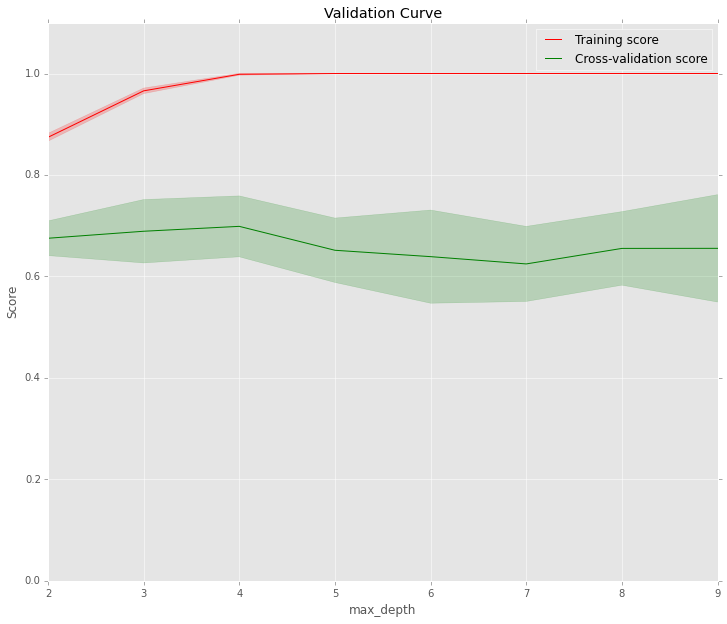

In [182]:
plot_validation_curve(estimator=GradientBoostingClassifier(learning_rate=0.09),X_train = X_train, y_train= y_train,
                     param_name="max_depth",param_range = range(2,10), semilog = False)

From the validation curve, we can clearly see that the accuracy gain after increasing max_depth beyond 3 is insignificant. We can also see a perfect training accuracy, which seems to indicate overfitting.

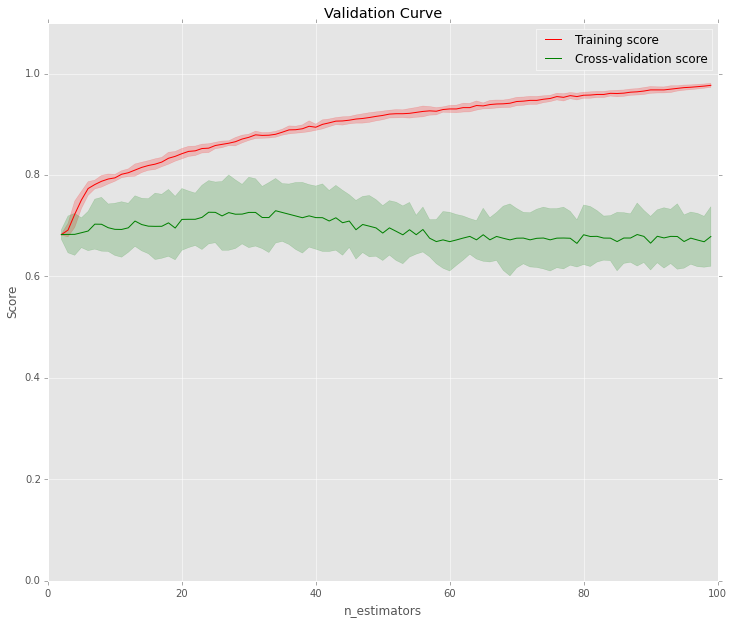

In [139]:
plot_validation_curve(estimator=GradientBoostingClassifier(),X_train= X_train, y_train= y_train, param_name="n_estimators",
                     param_range = range(2,100), semilog = False)

From the above graph, increasing ensembles seems to have little effect on CV score, and more over it is overfitting the training data as well after n_estimators > 85.

From the below graph, we can definitely fix all our hyperparameters. An ensemble of 9 trees, with a learning rate of 0.09 and max_depth of 3 seems to perform really well on this dataset. We arrived at these parameters by using RandomSearchCV and inferring from the learning and validation curves.

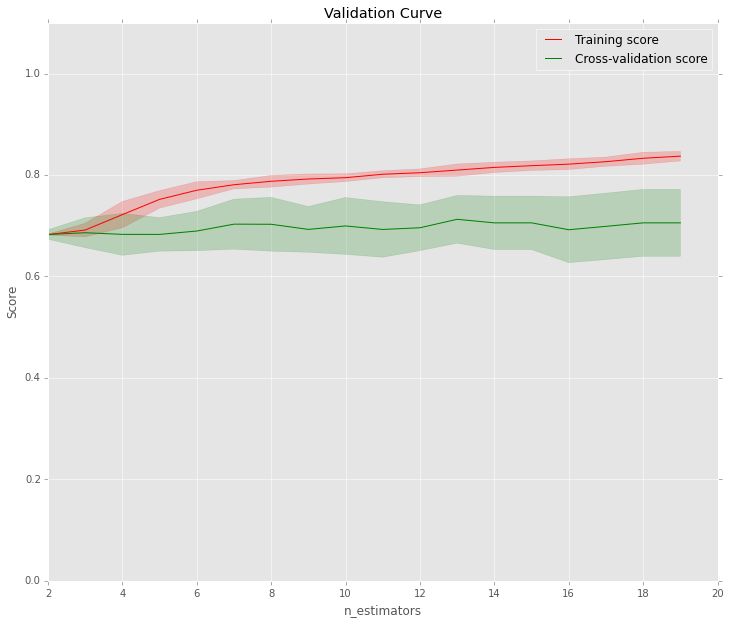

In [183]:
plot_validation_curve(estimator=GradientBoostingClassifier(max_depth=3),X_train= X_train, y_train= y_train, 
                      param_name="n_estimators",
                     param_range = range(2,20), semilog = False)

# Tuning support vector classifier

Support vector classifier uses hyperplanes to seperate the training data. Though it sounds like a simple techniques, it is quite robust in classifying various kinds of data. The optimization objective of a SVC is to find hyperplanes such that the gap between different classs is maximum. (also known as largest margin classifier). With the so-called kernel trick and a way of controlling using the margin, SVM's can be applied to various classificaton problems.

SVM's are quite robust to outliers in the training data but unlike logistic regression they don't give class probabilities. If your algorithm needs to find probabilites in addition to doing classification, Logistic regression would be a better choice. On the other hand, if you know before hand that the data is linearly seperable, SVC's can be very accurate. And, if you have a very small training set, but a large number of features (curse of dimensionality!) SVM's are really good at attacking such data.



In [192]:
from sklearn.svm import SVC
param = {"kernel":['linear','rbf'],
         "gamma":[0.0001,0.001,0.01,0.1],
         "C":[0.001,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09]
}
svcclf = GridSearchCV(SVC(), param_grid= param, cv=10,n_jobs= -1)
svcclf.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'kernel': ['linear', 'rbf'], 'C': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09], 'gamma': [0.0001, 0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [193]:
svcclf.best_params_

{'C': 0.05, 'gamma': 0.0001, 'kernel': 'linear'}

In [198]:
train_f1_score = predict_labels(svcclf.best_estimator_, X_train, y_train)
print train_f1_score
print "F1 score for test set: {}".format(predict_labels(svcclf.best_estimator_, X_test, y_test))

Predicting labels using SVC...
Done!
Prediction time (secs): 0.010
0.84188034188
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.830769230769


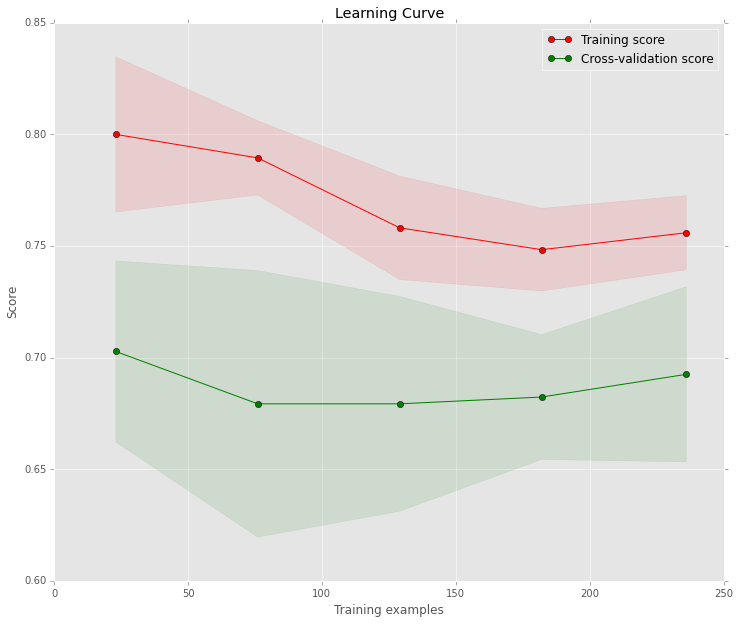

In [199]:
plot_learning_curve(svcclf.best_estimator_,X= X_train.values, y= y_train.values,title= 'Learning Curve',cv=10)

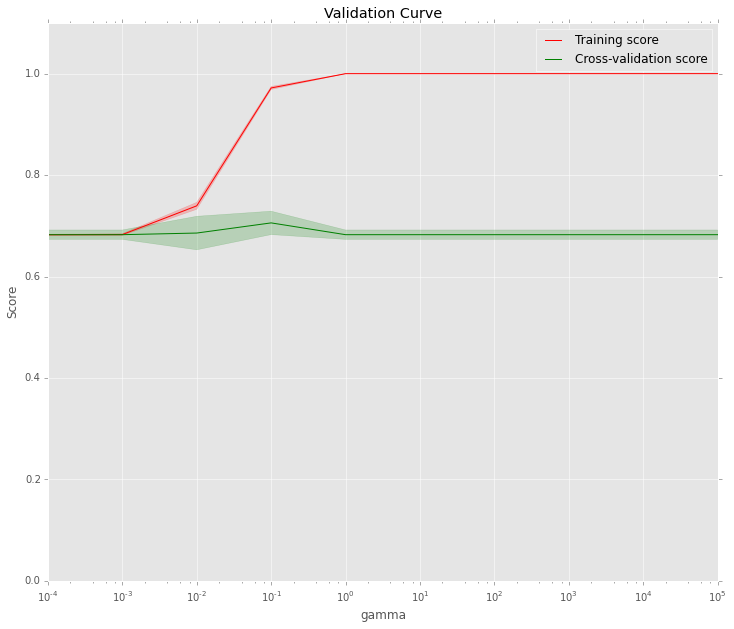

In [200]:
plot_validation_curve(estimator=SVC(),X_train= X_train, y_train= y_train, 
                      param_name="gamma",
                     param_range = np.logspace(-4, 5, 10), semilog = True)

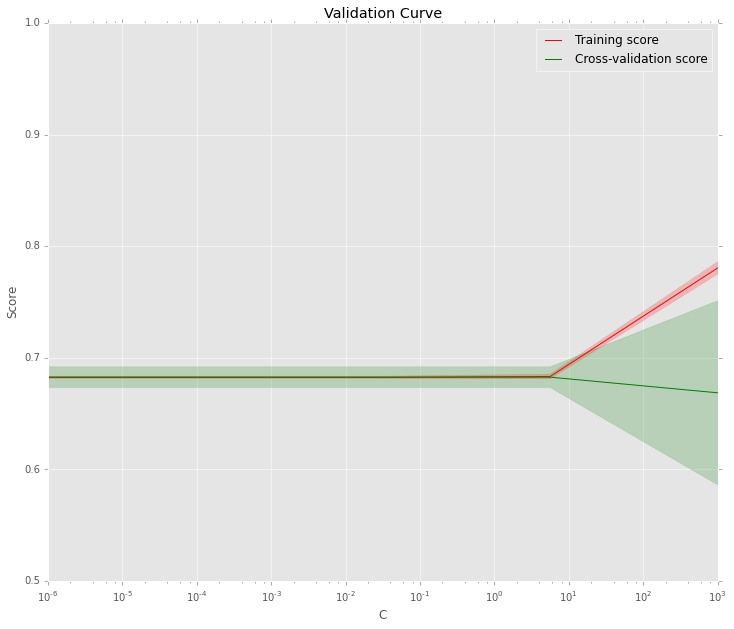

In [201]:
plot_validation_curve(estimator=SVC(gamma=0.0001),X_train= X_train, y_train= y_train, 
                      param_name="C",
                     param_range = np.logspace(-6, 3, 5), semilog = True, ylim= (0.5,1))

From the validation curves, we can select hyperparameters for this data set. A linear kernel with a cost of 0.05 seems to work well on this data.

# Best model 

In [202]:
print "F1 score for test set: {}".format(predict_labels(lrclf.best_estimator_, X_train, y_train))
print "F1 score for test set: {}".format(predict_labels(lrclf.best_estimator_, X_test, y_test))

Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.824524312896
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.830769230769


In [203]:
print "F1 score for test set: {}".format(predict_labels(gbcclfr.best_estimator_, X_train, y_train))
print "F1 score for test set: {}".format(predict_labels(gbcclfr.best_estimator_, X_test, y_test))

Predicting labels using GradientBoostingClassifier...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.864516129032
Predicting labels using GradientBoostingClassifier...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.8


In [204]:
print "F1 score for test set: {}".format(predict_labels(svcclf.best_estimator_, X_train, y_train))
print "F1 score for test set: {}".format(predict_labels(svcclf.best_estimator_, X_test, y_test))

Predicting labels using SVC...
Done!
Prediction time (secs): 0.010
F1 score for test set: 0.84188034188
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.830769230769


Based on the F1-score, I'm going with Logistic regression as my main classfier for this dataset. It seems to fit the data really well, and it is clearly not overfitting the training data.